Import Libraries (Mengimpor semua library yang dibutuhkan untuk proses data, mengembangkan, training, dan evaluasi model.)

In [ ]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from PIL import Image

connect drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Menentukan lokasi direktori dataset

In [ ]:
# Path ke direktori dataset
dataset_path = '/content/drive/MyDrive/test/dataset_regina_10120966'

In [ ]:
# Contoh untuk menampilkan gambar dari setiap kelas
kelas = ['kaca', 'kaleng', 'kardus', 'kertas', 'plastik']
print(kelas)

['kaca', 'kaleng', 'kardus', 'kertas', 'plastik']


In [ ]:
#set paramaeter size
img_height, img_width = 224, 224

In [ ]:
# Fungsi untuk memuat dan mengubah ukuran citra
def load_and_resize_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array /= 255.0  # Normalisasi citra
    return img, img_array

# Fungsi untuk menampilkan perbandingan citra asli dan citra yang telah di-resize
def display_comparison(image_path, target_size):
    # Memuat citra asli
    img_original = load_img(image_path)
    img_array_original = img_to_array(img_original)
    img_original_size = img_array_original.shape[:2]

    # Memuat dan mengubah ukuran citra
    img_resized, img_array_resized = load_and_resize_image(image_path, target_size)
    img_resized_size = img_array_resized.shape[:2]

    # Menampilkan citra asli dan citra yang telah di-resize
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_original)
    plt.title(f'Citra Asli\nSize: {img_original_size}')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(img_resized)
    plt.title(f'Citra yang telah diresize\nSize: {img_resized_size}')
    plt.axis('off')

    plt.show()

# Menampilkan hasil resize
display_comparison('/content/drive/MyDrive/test/dataset_regina_10120966/kaca/kaca_253.jpg', (img_height, img_width))

Visualisasi Citra Hasil Pengumpulan Data (Menampilkan beberapa gambar acak dari setiap kelas dalam grid subplot)

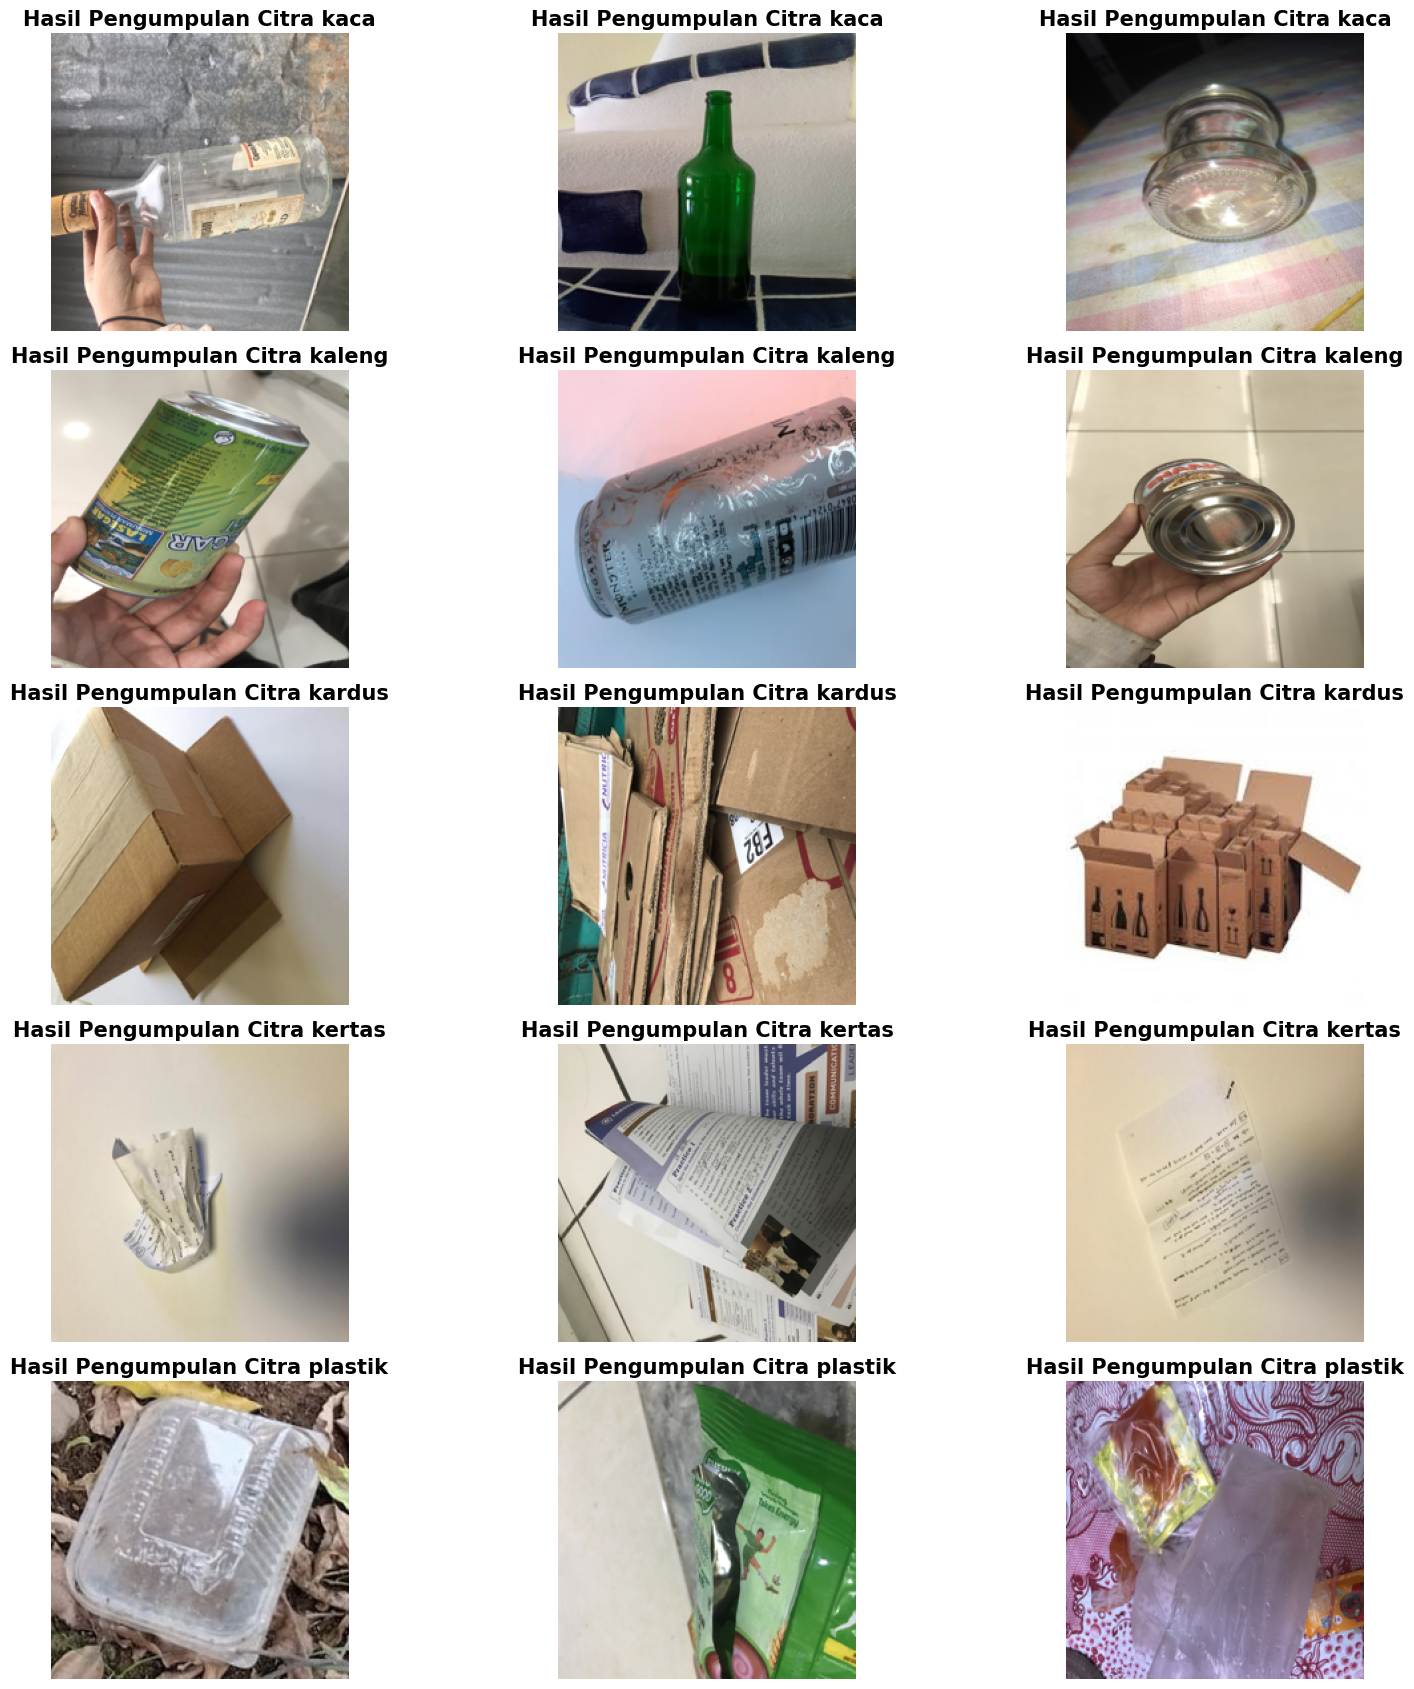

In [ ]:
def show_images(dataset_path, kelas, jmlh_citra_per_kls=3, img_size=(img_height, img_width)):

    fig, axes = plt.subplots(len(kelas), jmlh_citra_per_kls, figsize=(17, 17))  # Membuat grid subplot

    for i, kls in enumerate(kelas):
        # definisi kls buat class baru
        class_dir = os.path.join(dataset_path, kls)  # Path ke direktori kelas
        images = os.listdir(class_dir)  # Daftar gambar dalam direktori kelas
        random_images = random.sample(images, jmlh_citra_per_kls)  # Pilih gambar secara acak

        for j, image_name in enumerate(random_images):
            img_path = os.path.join(class_dir, image_name)  # Path lengkap gambar
            img = Image.open(img_path)  # Baca gambar
            img = img.resize(img_size)  # Resize gambar ke ukuran yang sama

            axes[i, j].imshow(img)  # Tampilkan gambar di subplot
            axes[i, j].axis('off')  # Nonaktifkan garis x y
            axes[i, j].set_title(f'Hasil Pengumpulan Citra {kls}', fontdict={'size':15, 'weight':'bold'})  # Menampilkan judul untuk setiap gambar

    plt.tight_layout()  # Mengatur layout subplot agar tidak saling tumpang tindih
    plt.show()  # Tampilkan gambar

# Panggil fungsi untuk menampilkan gambar
show_images(dataset_path, kelas, jmlh_citra_per_kls=3, img_size=(224, 224))

mengumpulkan informasi dasar tentang gambar dan label dalam format DataFrame

In [8]:
data = []

for label in kelas:
    class_dir = os.path.join(dataset_path, label) # Use 'label' instead of 'kls'
    for filename in os.listdir(class_dir):
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
            data.append({'filename': os.path.join(class_dir, filename), 'class': label}) # Use 'label' instead of 'kls'

df = pd.DataFrame(data)

In [9]:
print(df.head(100))

                                             filename class
0   /content/drive/MyDrive/test/dataset_regina_101...  kaca
1   /content/drive/MyDrive/test/dataset_regina_101...  kaca
2   /content/drive/MyDrive/test/dataset_regina_101...  kaca
3   /content/drive/MyDrive/test/dataset_regina_101...  kaca
4   /content/drive/MyDrive/test/dataset_regina_101...  kaca
..                                                ...   ...
95  /content/drive/MyDrive/test/dataset_regina_101...  kaca
96  /content/drive/MyDrive/test/dataset_regina_101...  kaca
97  /content/drive/MyDrive/test/dataset_regina_101...  kaca
98  /content/drive/MyDrive/test/dataset_regina_101...  kaca
99  /content/drive/MyDrive/test/dataset_regina_101...  kaca

[100 rows x 2 columns]


In [10]:
# Menampilkan DataFrame
print(df.tail(100))

                                               filename    class
3742  /content/drive/MyDrive/test/dataset_regina_101...  plastik
3743  /content/drive/MyDrive/test/dataset_regina_101...  plastik
3744  /content/drive/MyDrive/test/dataset_regina_101...  plastik
3745  /content/drive/MyDrive/test/dataset_regina_101...  plastik
3746  /content/drive/MyDrive/test/dataset_regina_101...  plastik
...                                                 ...      ...
3837  /content/drive/MyDrive/test/dataset_regina_101...  plastik
3838  /content/drive/MyDrive/test/dataset_regina_101...  plastik
3839  /content/drive/MyDrive/test/dataset_regina_101...  plastik
3840  /content/drive/MyDrive/test/dataset_regina_101...  plastik
3841  /content/drive/MyDrive/test/dataset_regina_101...  plastik

[100 rows x 2 columns]


Menampilkan Jumlah Citra per Kelas

In [11]:
# Menghitung jumlah citra per kelas
class_counts = df['class'].value_counts()

class_counts_df = class_counts.reset_index()
class_counts_df.columns = ['class', 'count']

In [12]:
# Menampilkan jumlah citra per kelas
print("\nJumlah Citra per Kelas:")
print(class_counts_df)

# Menampilkan jumlah total citra keseluruhan
total_citra_keseluruhan = len(df)
print("\nTotal Citra Keseluruhan:", total_citra_keseluruhan)


Jumlah Citra per Kelas:
     class  count
0   kardus    786
1   kaleng    777
2  plastik    764
3   kertas    758
4     kaca    757

Total Citra Keseluruhan: 3842


Visualisasi Distribusi Citra


*   Pie Chart (Distribusi Kelas)
- Bar Chart



In [13]:
# Membuat pie chart
plt.figure(figsize=(5, 5))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.2f%%', startangle=140, colors=['#F7FF56', '#9BEC00', '#4BE3AC', '#F66B0E', '#F5004F'], explode=[0.09, 0.09, 0.09, 0.09, 0.09])
plt.title('Distribusi Persebaran Citra Sampah Per Kelas', fontdict={'size': 13, 'weight': 'bold'})
plt.axis('equal')  # unit pada sumbu x dan y punya panjang yang sama, memastikan aspek rasio equal agar pie chart digambar sebagai lingkaran bukan menjadi elips/lainnya.
plt.show()

In [14]:
# Membuat bar plot
plt.figure(figsize=(5, 5))
class_counts.plot(kind='bar', color=['#F7FF56', '#9BEC00', '#4BE3AC', '#F66B0E', '#F5004F'])
plt.title('Distribusi Persebaran Citra Sampah Per Kelas', fontdict={'size': 13, 'weight': 'bold'})
plt.xlabel('Kelas')
plt.ylabel('Jumlah Citra')
plt.xticks(rotation=0)
plt.show()

Definisi 2 list kosong untuk menyimpan data citra dan label kelas

In [15]:
# Mengisi list dengan informasi gambar dan label
data_gambar = []
label = []

Mengisi List dengan Citra dan Label (mengumpulkan gambar dari direktori dan mengubahnya menjadi array numpy)

In [16]:
for i, kelas_i in enumerate(kelas):
    path_kelas = os.path.join(dataset_path, kelas_i)
    if not os.path.exists(path_kelas):
        print(f"Directory {path_kelas} does not exist.")
        continue

    for gambar in os.listdir(path_kelas):
        if gambar.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                path_gambar = os.path.normpath(os.path.join(path_kelas, gambar))
                gambar = load_img(path_gambar, target_size=(224,224))
                gambar_array = img_to_array(gambar)
                data_gambar.append(gambar_array)
                label.append(i)
            except Exception as e:
                print(f"Error loading image {path_gambar}: {e}")

Mengubah list menjadi array numpy

In [17]:
# Mengubah list menjadi array numpy
data_gambar = np.array(data_gambar)
label = np.array(label)

In [18]:
# Menampilkan dimensi array dan beberapa contoh data
print("Dimensi data_gambar:", data_gambar.shape)
print("Dimensi label:", label.shape)

# Menampilkan beberapa contoh data dan label
print("Contoh data_gambar 2 elemen pertama:")
print(data_gambar[:2])

print("Contoh label 2 elemen pertama:")
print(label[:2])

Dimensi data_gambar: (3842, 224, 224, 3)
Dimensi label: (3842,)
Contoh data_gambar 2 elemen pertama:
[[[[174. 170. 161.]
   [216. 209. 201.]
   [214. 207. 201.]
   ...
   [210. 203. 185.]
   [225. 217. 196.]
   [210. 202. 181.]]

  [[177. 172. 166.]
   [225. 218. 212.]
   [210. 203. 197.]
   ...
   [229. 220. 203.]
   [205. 197. 178.]
   [202. 194. 175.]]

  [[193. 188. 182.]
   [212. 205. 199.]
   [205. 198. 192.]
   ...
   [191. 182. 165.]
   [187. 178. 161.]
   [188. 179. 162.]]

  ...

  [[181. 190. 197.]
   [215. 224. 231.]
   [222. 229. 239.]
   ...
   [193. 189. 186.]
   [181. 177. 174.]
   [179. 175. 172.]]

  [[204. 211. 221.]
   [228. 235. 245.]
   [207. 214. 224.]
   ...
   [207. 202. 198.]
   [196. 191. 188.]
   [178. 173. 170.]]

  [[206. 215. 222.]
   [229. 238. 245.]
   [199. 208. 217.]
   ...
   [193. 190. 185.]
   [166. 161. 158.]
   [173. 169. 166.]]]


 [[[ 43.  38.  32.]
   [ 43.  38.  32.]
   [ 47.  44.  35.]
   ...
   [ 46.  42.  31.]
   [ 54.  52.  40.]
   [ 46. 

Split Data (Train 80, Val 10, Test 10)

In [19]:
# Membagi data menjadi data train, validasi, dan test
X_train, X_test, y_train, y_test = train_test_split(data_gambar, label, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Variabel yang digunakan pada pemisahan data:
# - X_train: berisi array gambar untuk data latih.
# - X_test: berisi array gambar untuk data uji.
# - y_train: berisi label kelas yang sesuai untuk data latih.
# - y_test: berisi label kelas yang sesuai untuk data uji.

In [20]:
print("Jumlah gambar pada data latih:", len(X_train))
print("Jumlah gambar pada data validasi:", len(X_val))
print("Jumlah gambar pada data uji:", len(X_test))

Jumlah gambar pada data latih: 3073
Jumlah gambar pada data validasi: 384
Jumlah gambar pada data uji: 385


In [21]:
# Menghitung jumlah sampel pada setiap set
num_train = len(X_train)
num_val = len(X_val)
num_test = len(X_test)

# Menghitung proporsi setiap set
train_ratio = num_train / (num_train + num_val + num_test)
val_ratio = num_val / (num_train + num_val + num_test)
test_ratio = num_test / (num_train + num_val + num_test)

# Menampilkan proporsi setiap set
print("Proporsi Data Training:", train_ratio)
print("Proporsi Data Validation:", val_ratio)
print("Proporsi Data Testing:", test_ratio)

Proporsi Data Training: 0.7998438313378449
Proporsi Data Validation: 0.09994794377928162
Proporsi Data Testing: 0.10020822488287351


In [22]:
# Menampilkan dimensi data setelah pembagian
print("Dimensi X_train:", X_train.shape)
print("Dimensi y_train:", y_train.shape)
print("Dimensi X_val:", X_val.shape)
print("Dimensi y_val:", y_val.shape)
print("Dimensi X_test:", X_test.shape)
print("Dimensi y_test:", y_test.shape)

Dimensi X_train: (3073, 224, 224, 3)
Dimensi y_train: (3073,)
Dimensi X_val: (384, 224, 224, 3)
Dimensi y_val: (384,)
Dimensi X_test: (385, 224, 224, 3)
Dimensi y_test: (385,)


Visualisasi Bar Chart (Distribusi Jumlah Citra tiap kelas)

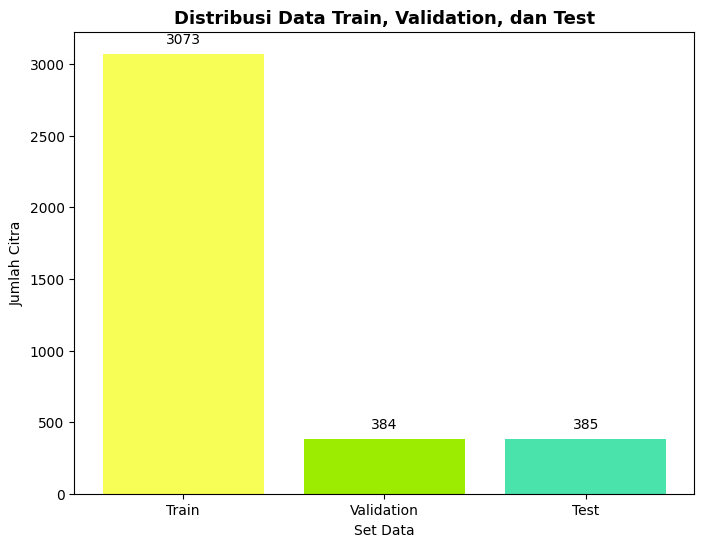

In [23]:
# Data untuk bar chart
kategori = ['Train', 'Validation', 'Test']
jumlah = [num_train, num_val, num_test]

# Membuat bar chart
plt.figure(figsize=(8, 6))
plt.bar(kategori, jumlah, color=['#F7FF56', '#9BEC00', '#4BE3AC'])
plt.xlabel('Set Data')
plt.ylabel('Jumlah Citra')  # Mengganti 'Proporsi' dengan 'Jumlah Citra'
plt.title('Distribusi Data Train, Validation, dan Test', fontdict={'size': 13, 'weight': 'bold'})

# Menambahkan label di atas setiap bar
for i, v in enumerate(jumlah):
    plt.text(i, v + 50, str(v), ha='center', va='bottom')  # Menyesuaikan jarak label

plt.show()

Pre-processing Data
*   Normalisasi
*   One-Hot Encoding



In [24]:
X_train = tf.keras.applications.vgg16.preprocess_input(X_train)
X_val = tf.keras.applications.vgg16.preprocess_input(X_val)
X_test = tf.keras.applications.vgg16.preprocess_input(X_test)

In [25]:
# Mengubah label menjadi one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(kelas))
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(kelas))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(kelas))

# Menampilkan dimensi dan contoh hasil one-hot encoding
#menampilkan 5 elemen pertama dari array atau list.
print("Dimensi y_train:", y_train.shape)
print("Contoh y_train 5 elemen pertama:")
print(y_train[:5])  # Menampilkan 5 contoh pertama

print("Dimensi y_val:", y_val.shape)
print("Contoh y_val 5 elemen pertama):")
print(y_val[:5])  # Menampilkan 5 contoh pertama

print("Dimensi y_test:", y_test.shape)
print("Contoh y_test 5 elemen pertama):")
print(y_test[:5])  # Menampilkan 5 contoh pertama

Dimensi y_train: (3073, 5)
Contoh y_train 5 elemen pertama:
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]
Dimensi y_val: (384, 5)
Contoh y_val 5 elemen pertama):
[[0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]
Dimensi y_test: (385, 5)
Contoh y_test 5 elemen pertama):
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]


menampilkan beberapa gambar dari dataset setelah melalui proses resize dan normalisasi

In [27]:
def display_random_images_with_labels(images, labels, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(len(images), num_images, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx])
        plt.axis('off')
        # Menambahkan judul dengan nama kelas
        label_index = np.argmax(labels[idx])  # Mengambil indeks kelas dari one-hot encoded label
        plt.title(class_names[label_index], fontsize=10)
    plt.show()

# Menampilkan gambar secara acak dengan label
display_random_images_with_labels(X_train, y_train, kelas)

menampilkan dimensi dari data gambar untuk pelatihan model

In [28]:
# Menampilkan dimensi data gambar
print("Dimensi Data Training:")
print("Jumlah gambar:", X_train.shape[0])  # Jumlah gambar di data latih
print("Tinggi gambar:", X_train.shape[1])  # Tinggi gambar (misalnya 224 untuk 224x224)
print("Lebar gambar:", X_train.shape[2])   # Lebar gambar (misalnya 224 untuk 224x224)
print("Jumlah saluran warna:", X_train.shape[3])  # Jumlah saluran warna (misalnya 3 untuk RGB)

Dimensi Data Training:
Jumlah gambar: 3073
Tinggi gambar: 224
Lebar gambar: 224
Jumlah saluran warna: 3


Fungsi untuk menampilkan rentang nilai piksel data pelatihan (X_train) setelah preprocessing dengan tf.keras.applications.vgg16.preprocess_input()

In [29]:
# Menampilkan rentang nilai piksel
print("Rentang Nilai Piksel Data Training:")
print("Nilai Piksel Minimum:", np.min(X_train))
print("Nilai Piksel Maksimum:", np.max(X_train))

Rentang Nilai Piksel Data Training:
Nilai Piksel Minimum: -123.68
Nilai Piksel Maksimum: 151.061


Augmentasi Data

In [30]:
# Augmentasi Citra untuk Data Pelatihan
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [31]:
# Normalisasi untuk Data Validasi dan Uji
val_datagen = ImageDataGenerator()  # Tidak ada augmentasi untuk data validasi
test_datagen = ImageDataGenerator()   # Tidak ada augmentasi untuk data uji

In [32]:
# Membuat Generator untuk Data Pelatihan, Validasi, dan Uji
train_generator = train_datagen.flow(
    X_train,  # Data Gambar Pelatihan
    y_train,  # Label One-Hot Encoding untuk Data Pelatihan
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val,    # Data Gambar Validasi
    y_val,    # Label One-Hot Encoding untuk Data Validasi
    batch_size=32,
    shuffle=False
)

test_generator = test_datagen.flow(
    X_test,   # Data Gambar Uji
    y_test,   # Label One-Hot Encoding untuk Data Uji
    batch_size=32,
    shuffle=False
)

In [33]:
print(train_generator)
print(val_generator)

In [34]:
# Mengambil beberapa batch dari generator
x_batch, y_batch = next(train_generator)
print(f"Batch labels (one-hot encoded): {y_batch[:5]}")
print(f"Batch labels (integer): {np.argmax(y_batch[:5], axis=1)}")

Batch labels (one-hot encoded): [[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
Batch labels (integer): [2 1 1 4 4]


Menampilkan Hasil Augmentasi

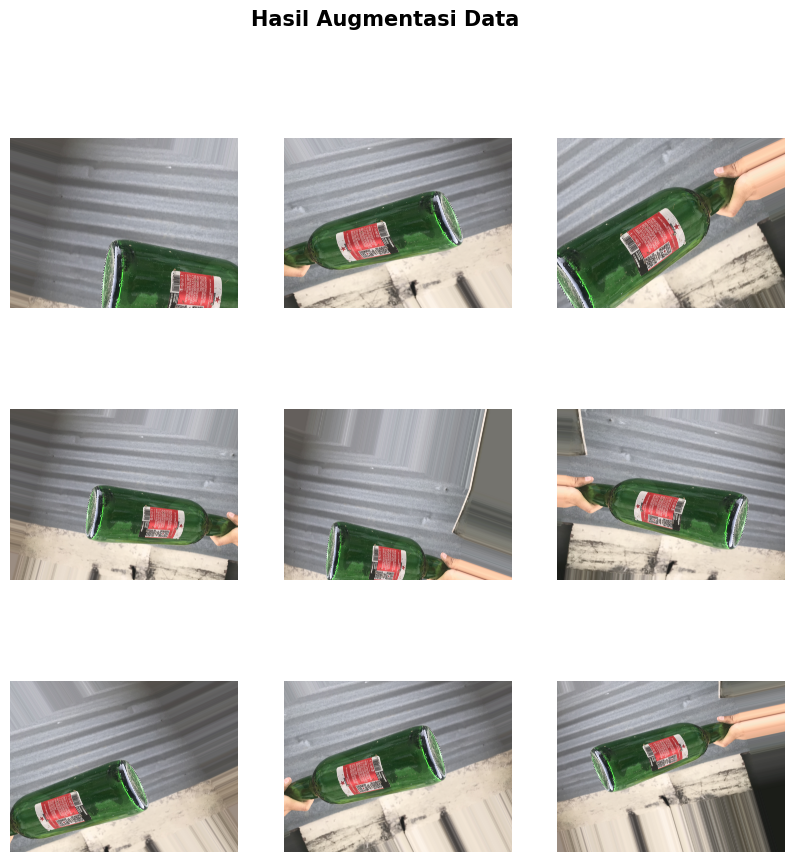

In [35]:
# Menampilkan beberapa contoh augmentasi dari satu gambar
img_path = '/content/drive/MyDrive/test/dataset_regina_10120966/kaca/kaca_021.jpg'  # Path gambar
img = load_img(img_path)  # Memuat gambar
x = img_to_array(img)  # Mengonversi gambar menjadi array
x = x.reshape((1,) + x.shape)  # Reshape ke (1, height, width, channels)

i = 0
plt.figure(figsize=(10, 10))  # Ukuran figure
for batch in train_datagen.flow(x, batch_size=1):  # Menghasilkan batch augmentasi dari gambar
    plt.subplot(3, 3, i + 1)  # Membuat subplot 3x3
    plt.imshow(batch[0].astype('uint8'))  # Menampilkan gambar
    plt.axis('off')  # Menonaktifkan axis
    i += 1
    if i % 9 == 0:  # Menghentikan loop setelah 9 augmentasi
        break
plt.suptitle('Hasil Augmentasi Data', fontsize=15, fontweight='bold')  # Menambahkan judul
plt.show()  # Menampilkan figure

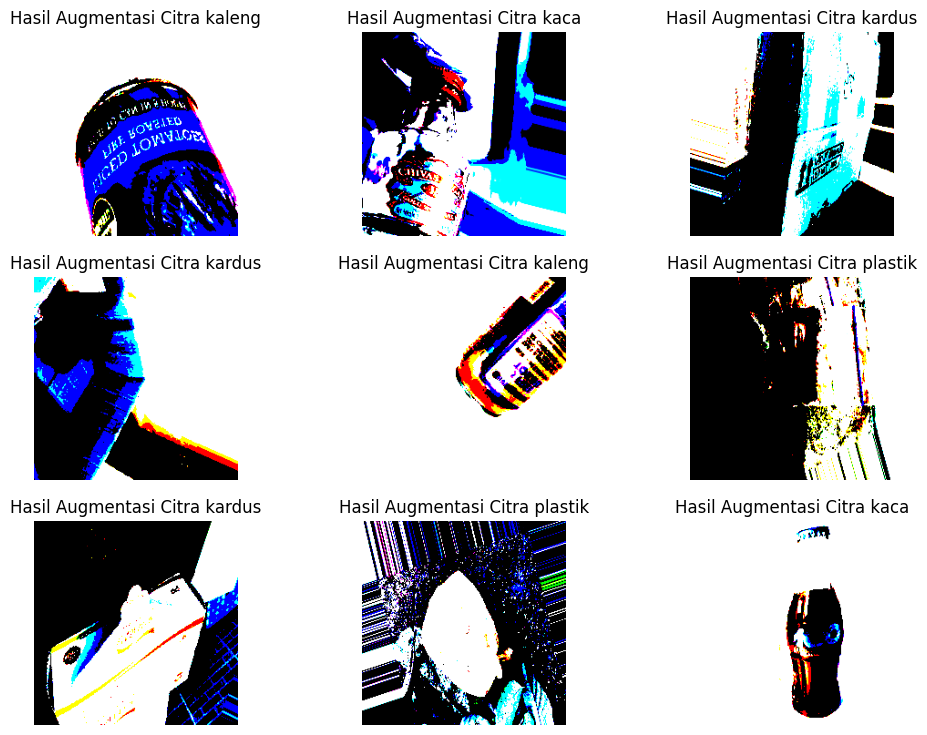

In [46]:
# Menampilkan beberapa contoh hasil augmentasi
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])

    # Mengambil label kelas dari y_batch
    label_index = np.argmax(y_batch[i])  # Mengambil indeks kelas dengan nilai tertinggi
    label_name = kelas[label_index]  # Mengambil nama kelas berdasarkan indeks

    plt.title(f"Hasil Augmentasi Citra {label_name}")
    plt.axis('off')
plt.show()

In [47]:
# Menampilkan dimensi dan rentang nilai piksel
print("Dimensi Data Gambar Augmentasi:")
print("Tinggi gambar:", x_batch.shape[1])
print("Lebar gambar:", x_batch.shape[2])
print("Jumlah saluran warna:", x_batch.shape[3])

# Rentang nilai piksel
print("Rentang Nilai Piksel Gambar Augmentasi:")
print("Nilai Piksel Minimum:", np.min(x_batch))
print("Nilai Piksel Maksimum:", np.max(x_batch))

Dimensi Data Gambar Augmentasi:
Tinggi gambar: 224
Lebar gambar: 224
Jumlah saluran warna: 3
Rentang Nilai Piksel Gambar Augmentasi:
Nilai Piksel Minimum: -123.68
Nilai Piksel Maksimum: 151.061


Mengembangkan Model VGG-16

In [48]:
# Membangun model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [49]:
# Freeze layer VGG16
for layer in base_model.layers:
    layer.trainable = False

In [50]:
# Menambahkan layer-layer baru setelah base model (VGG16)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling setelah base model
# Dense layer pertama dengan 512 neuron
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout untuk mencegah overfitting
# Dense layer kedua dengan 256 neuron
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout lagi

# Output layer dengan softmax sesuai dengan jumlah kelas
output_prediksi = Dense(len(kelas), activation='softmax')(x)

# Membuat model baru
model = Model(inputs=base_model.input, outputs=output_prediksi)

# Menampilkan summary model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,6

 Total params: 15,109,957 (57.64 MB)

 Trainable params: 395,269 (1.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [51]:
# Mengompilasi model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [52]:
# Callback
# Menentukan callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    verbose=1,
    restore_best_weights=True
    )

model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/test/best_model_{epoch:02d}_{val_accuracy:.2f}.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

In [53]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_learning_rate]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.4078 - loss: 3.0512
Epoch 1: val_accuracy improved from -inf to 0.76042, saving model to /content/drive/MyDrive/test/best_model_01_0.76.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 64s 461ms/step - accuracy: 0.4087 - loss: 3.0400 - val_accuracy: 0.7604 - val_loss: 0.6739 - learning_rate: 0.0010
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.6323 - loss: 0.9975
Epoch 2: val_accuracy improved from 0.76042 to 0.78906, saving model to /content/drive/MyDrive/test/best_model_02_0.79.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 428ms/step - accuracy: 0.6323 - loss: 0.9974 - val_accuracy: 0.7891 - val_loss: 0.5500 - learning_rate: 0.0010
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.6760 - loss: 0.8388
Epoch 3: val_accuracy improved from 0.78906 to 0.80990, saving model to /content/drive/MyDrive/test/best_model_03_0.81.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 83s 432ms/step - accuracy: 0.6760 - loss: 0.8389 - val_accuracy: 0.809

Fine Tuning & Melatih Ulang Model

In [54]:
# Unfreeze beberapa lapisan terakhir dari base_model
for layer in base_model.layers[-3:]:
    layer.trainable = True

In [55]:
# Mengompilasi model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [56]:
# Melatih ulang model
history_fine_tuning = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_learning_rate]
)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.7896 - loss: 0.6371
Epoch 1: val_accuracy did not improve from 0.89323
97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 483ms/step - accuracy: 0.7897 - loss: 0.6362 - val_accuracy: 0.8776 - val_loss: 0.4338 - learning_rate: 1.0000e-04
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8316 - loss: 0.4863
Epoch 2: val_accuracy did not improve from 0.89323
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 420ms/step - accuracy: 0.8317 - loss: 0.4858 - val_accuracy: 0.8932 - val_loss: 0.3527 - learning_rate: 1.0000e-04
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8779 - loss: 0.3689
Epoch 3: val_accuracy improved from 0.89323 to 0.90104, saving model to /content/drive/MyDrive/test/best_model_03_0.90.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 432ms/step - accuracy: 0.8779 - loss: 0.3687 - val_accuracy: 0.9010 - val_loss: 0.3264 - learning_rate: 1.0000e-04
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8892 - 

Evaluasi Model

In [62]:
# Evaluasi model dengan generator
loss, accuracy = model.evaluate(train_generator, verbose=1)
print("Loss pada data training:", loss)
print("Akurasi pada data training:", accuracy)

97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 414ms/step - accuracy: 0.9867 - loss: 0.0555
Loss pada data training: 0.04711524769663811
Akurasi pada data training: 0.9899121522903442


In [63]:
# Evaluasi model dengan generator
loss, accuracy = model.evaluate(val_generator, verbose=1)
print("Loss pada data validation:", loss)
print("Akurasi pada data validation:", accuracy)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9078 - loss: 0.2362
Loss pada data validation: 0.27235397696495056
Akurasi pada data validation: 0.9088541865348816


In [59]:
# Evaluasi model dengan generator
loss, accuracy = model.evaluate(test_generator, verbose=1)
print("Loss pada data uji:", loss)
print("Akurasi pada data uji:", accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9438 - loss: 0.2615
Loss pada data uji: 0.3439396917819977
Akurasi pada data uji: 0.9350649118423462


Visualisasi Hasil Pelatihan (Learning Curve)

In [64]:
# plot kurva loss dan akurasi selama pelatihan model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Visualisasi Hasil Fine Tuning

In [65]:
# Plot kurva loss dan akurasi untuk fine-tuning
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine_tuning.history['loss'], label='Training Loss')
plt.plot(history_fine_tuning.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves (Fine-tuning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fine_tuning.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tuning.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves (Fine-tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Membuat Prediksi pada Data Test

In [72]:
# Membuat prediksi pada data uji
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Mengambil label sebenarnya dari generator data uji
y_true = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]
    y_true.extend(np.argmax(labels, axis=1))

# Mengubah list menjadi array numpy
y_pred_classes = np.array(y_pred_classes)
y_true = np.array(y_true)

# Menampilkan hasil prediksi
print("Hasil Prediksi:")
print(y_pred_classes[:10])  # Menampilkan beberapa hasil prediksi
print("Label Sebenarnya:")
print(y_true[:10])  # Menampilkan beberapa label sebenarnya

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step
Hasil Prediksi:
[1 0 2 4 2 1 4 3 2 4]
Label Sebenarnya:
[1 0 2 4 2 1 4 3 4 4]


Metrik Evaluasi Lengkap

In [73]:
# Menghitung metrik evaluasi
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Menampilkan metrik evaluasi dengan format angka desimal
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Menampilkan laporan klasifikasi
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=kelas))

Accuracy: 0.9351
Precision: 0.9367
Recall: 0.9351
F1 Score: 0.9347

Classification Report:
              precision    recall  f1-score   support

        kaca       0.96      0.95      0.95        92
      kaleng       0.91      0.99      0.95        76
      kardus       0.91      0.94      0.93        86
      kertas       0.93      0.94      0.93        68
     plastik       0.98      0.84      0.91        63

    accuracy                           0.94       385
   macro avg       0.94      0.93      0.93       385
weighted avg       0.94      0.94      0.93       385



Menampilkan Confusion Matrix

Confusion Matrix:
[[87  4  0  0  1]
 [ 0 75  1  0  0]
 [ 0  2 81  3  0]
 [ 0  0  4 64  0]
 [ 4  1  3  2 53]]


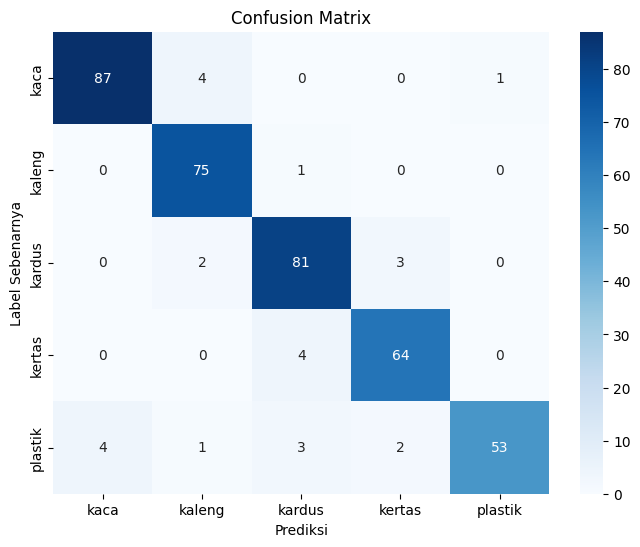

In [84]:
# Nama-nama kelas
kelas = ['kaca', 'kaleng', 'kardus', 'kertas', 'plastik']

# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Menampilkan confusion matrix
print("Confusion Matrix:")
print(cm)

# Menampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=kelas, yticklabels=kelas)
plt.xlabel('Prediksi')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix')
plt.show()

Menampilkan Beberapa Gambar Prediksi

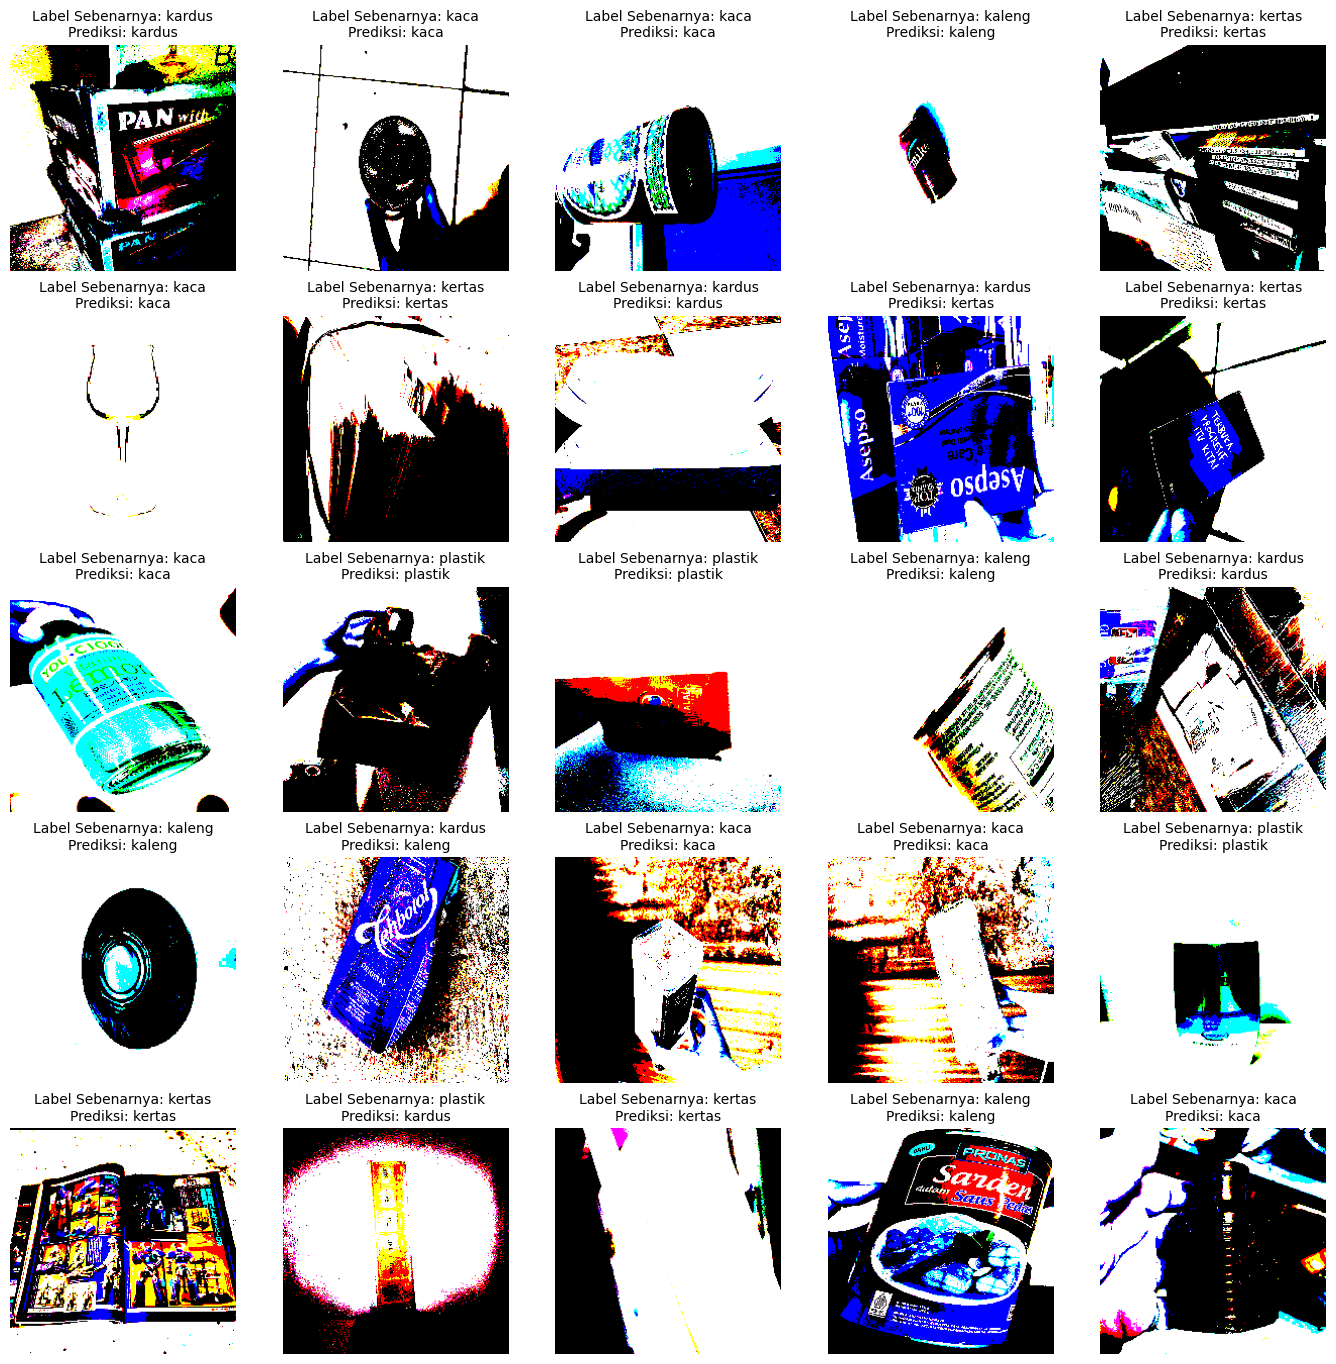

In [98]:
# Menampilkan beberapa gambar prediksi yang benar dan salah secara acak
def display_predictions(images, labels_true, labels_pred, class_names, num_images=25):
    plt.figure(figsize=(17, 17))

    # Memilih indeks gambar secara acak
    random_indices = np.random.choice(len(images), num_images, replace=False)

    for i, idx in enumerate(random_indices):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[idx])
        true_label = class_names[labels_true[idx]]
        pred_label = class_names[labels_pred[idx]]
        plt.title(f"Label Sebenarnya: {true_label}\nPrediksi: {pred_label}", fontsize=10)
        plt.axis('off')
    plt.show()

# Ambil beberapa contoh gambar dari data uji secara acak
display_predictions(X_test, y_true, y_pred_classes, kelas, num_images=25)

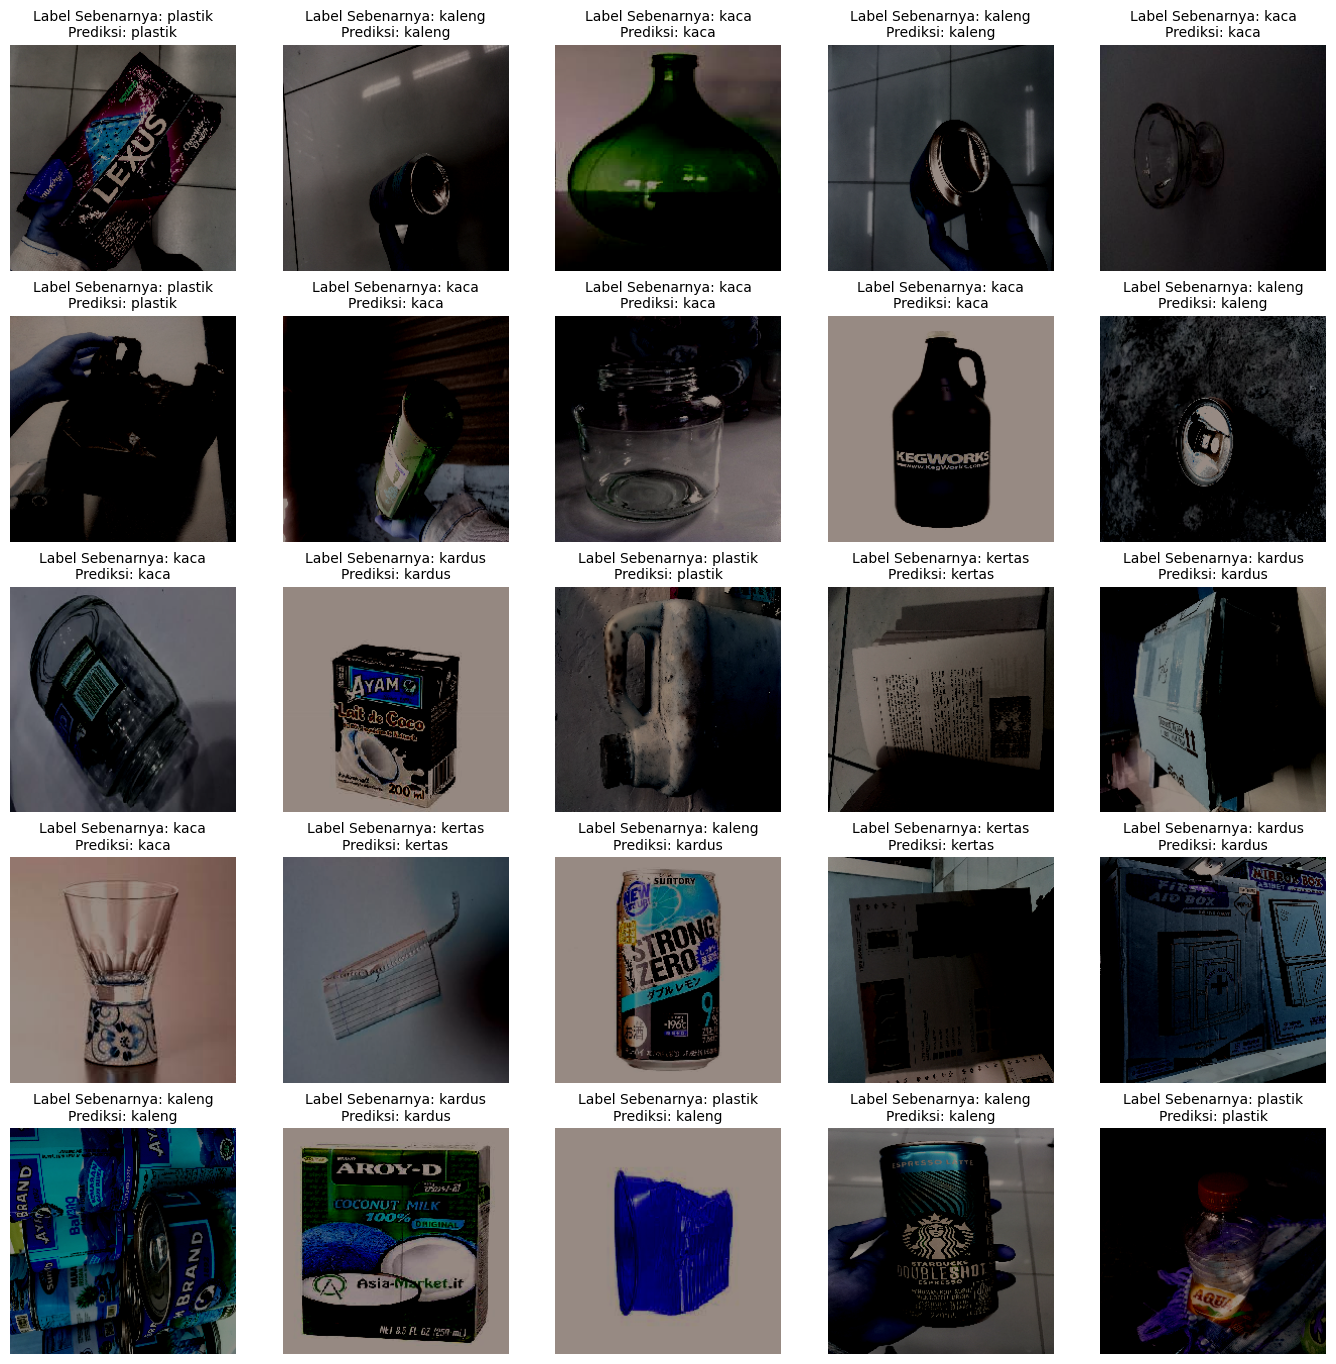

In [100]:
# Menampilkan beberapa gambar prediksi yang benar dan salah secara acak dengan normalisasi
def display_predictions(images, labels_true, labels_pred, class_names, num_images=25):
    plt.figure(figsize=(17, 17))

    # Memilih indeks gambar secara acak
    random_indices = np.random.choice(len(images), num_images, replace=False)

    for i, idx in enumerate(random_indices):
        plt.subplot(5, 5, i + 1)
        # Normalisasi gambar
        normalized_image = images[idx] / 255.0
        plt.imshow(normalized_image)
        true_label = class_names[labels_true[idx]]
        pred_label = class_names[labels_pred[idx]]
        plt.title(f"Label Sebenarnya: {true_label}\nPrediksi: {pred_label}", fontsize=10)
        plt.axis('off')
    plt.show()

# Ambil beberapa contoh gambar dari data uji secara acak
display_predictions(X_test, y_true, y_pred_classes, kelas, num_images=25)

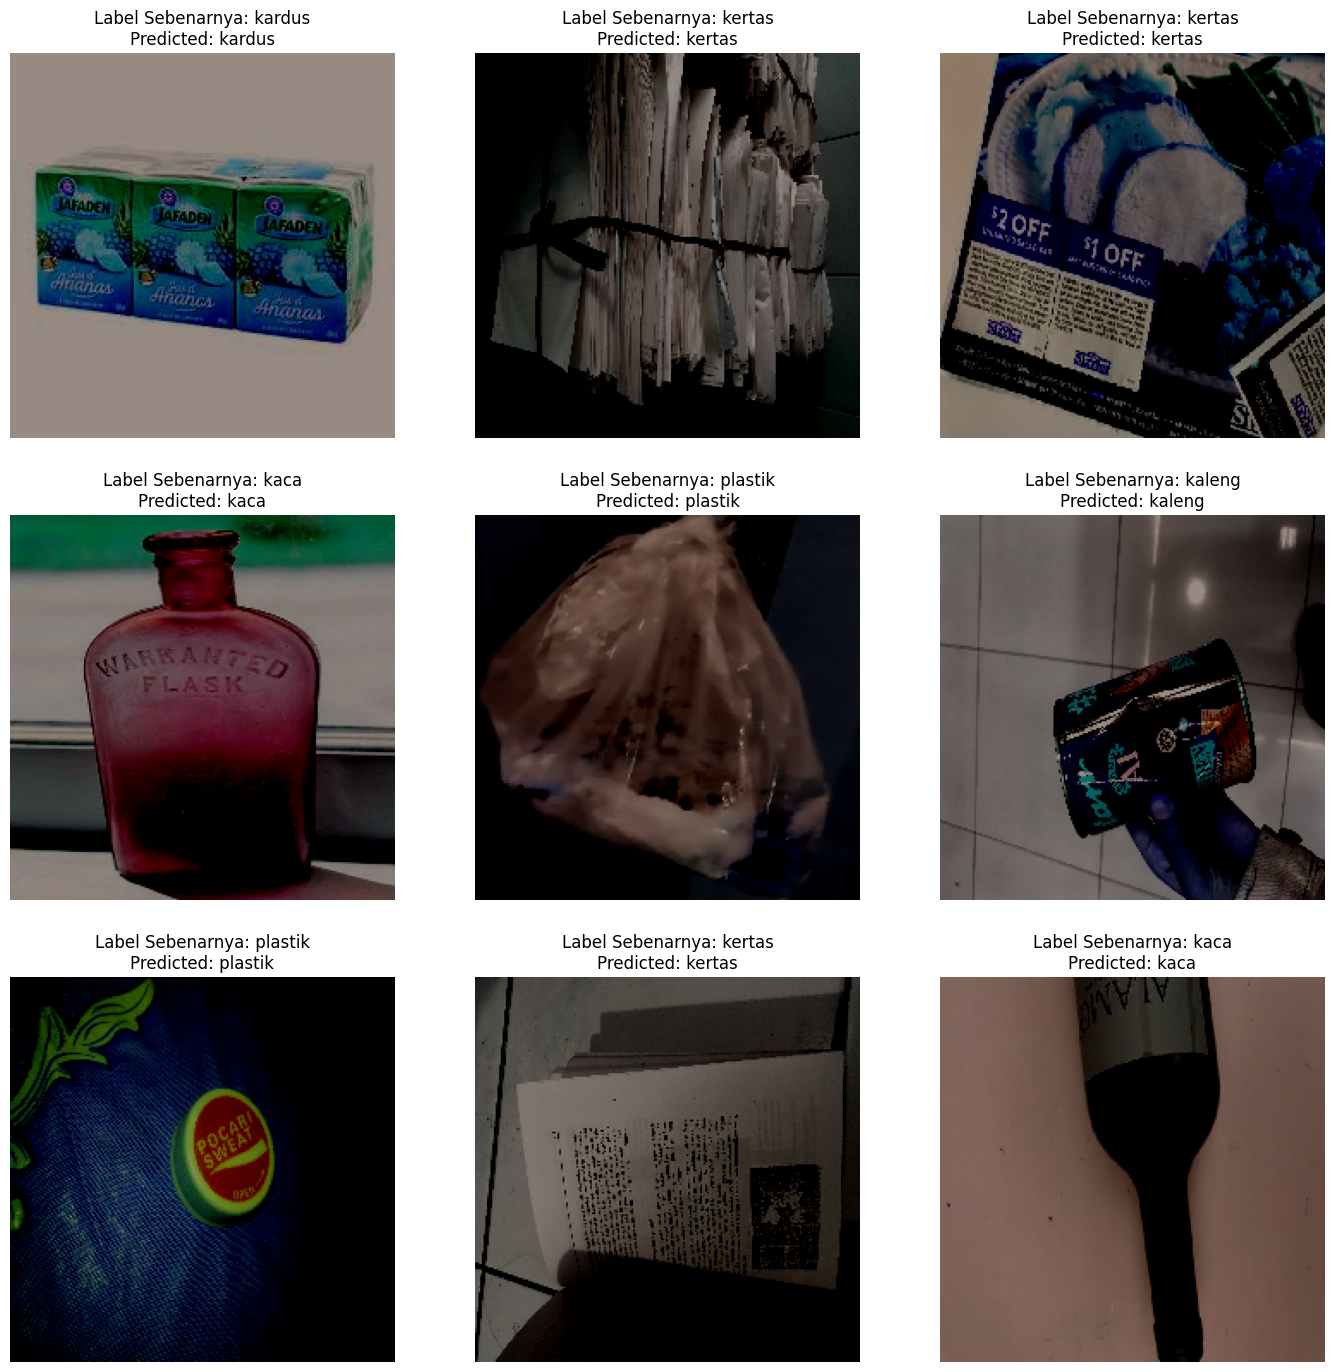

In [99]:
# Menampilkan beberapa gambar prediksi
num_images_to_display = 9
plt.figure(figsize=(17, 17))
for i in range(num_images_to_display):
    index = np.random.randint(0, len(X_test))
    image = X_test[index]
    true_label = np.argmax(y_test[index])
    predicted_label = y_pred_classes[index]

    plt.subplot(3, 3, i + 1)
    plt.imshow(image / 255.0)  # Normalisasi gambar
    plt.title(f"Label Sebenarnya: {kelas[true_label]}\nPredicted: {kelas[predicted_label]}")
    plt.axis('off')
plt.show()

In [101]:
# Menyimpan model
model.save('/content/drive/MyDrive/test/revisi_model_regina.keras')